In [1]:
setwd('../../')
source('.Rprofile')
setwd('./evaluation/analysis')

library(ggplot2)
library(tidyverse)
library(plyr)
library(dplyr)
library(ggpubr)
library(reshape2)
library(stringr)

ℹ Using R 4.2.1 (lockfile was generated with R 4.1.3)
[1] "/flash/grp/gglab/xiacr/SLAT-dev/renv/library/R-4.2/x86_64-pc-linux-gnu"         
[2] "/flash/grp/gglab/xiacr/SLAT-dev/renv/sandbox/R-4.2/x86_64-pc-linux-gnu/9a444a72"


Warning message in system2("poetry", c("env", "info", "--path"), stdout = TRUE):
“running command ''poetry' env info --path' had status 1”


python:         /flash/grp/gglab/xiacr/SLAT-dev/conda/bin/python
libpython:      /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/libpython3.8.so
pythonhome:     /flash/grp/gglab/xiacr/SLAT-dev/conda:/flash/grp/gglab/xiacr/SLAT-dev/conda
version:        3.8.17 | packaged by conda-forge | (default, Jun 16 2023, 07:06:00)  [GCC 11.4.0]
numpy:          /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by use_python function
[1] "/flash/grp/gglab/xiacr/SLAT-dev/conda/lib:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/flash/grp/gglab/xiacr/SpatialLR-dev/resource/jdk1.8.0_361/lib/server:/opt/slurm-22.05.2/lib:/opt/slurm-22.05.2/lib/slurm:"


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘ggpubr’


The following 

# Hyperparameters of SLAT
## Joint accuracy

In [23]:
df <- read.csv("../results/hyperparam_slat.csv") 
df <- df %>%
        mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
        mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
        mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq')) %>%
    mutate(feature_type = replace(feature_type, feature_type == 'dpca', 'Cross dataset SVD'))
df$dataset <- factor(df$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
df %>% tail(3)

,dataset,datasize,k_neighbors,feature_type,feature_dim,epochs,LGCN_layer,mlp_hidden,hidden_size,alpha,⋯,lr_recon,batch_d_per_iter,batch_r_per_iter,smooth,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<fct>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
958,Visium,8000,5,Cross dataset SVD,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,5,0.8485698,0.06658874,0.6811554,0.7835109,16.51446
959,Visium,8000,5,Cross dataset SVD,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,6,0.8407179,0.06791686,0.6867639,0.7966910,14.33310
960,Visium,8000,5,Cross dataset SVD,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,7,0.8398766,0.06528853,0.6828379,0.7860348,15.81811


In [24]:
default_param <- c(k_neighbors =20, feature_type='Cross dataset SVD', feature_dim=50 ,epochs = 6, LGCN_layer = 1,
                    mlp_hidden = 256, hidden_size = 2048, alpha = 0.01, anchor_scale = "0.8",
                   lr_mlp = 0.0001, lr_wd = 0.0001, lr_recon = 0.01, batch_d_per_iter = 7, batch_r_per_iter = 10, smooth=5)
scores <- c("global_score")

In [32]:
plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "dataset", palette = c("aaas"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Joint accuracy") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20,
            legend = "right", legend.title='Dataset', ylim = c(0.25, 0.75)) +
            # geom_text(aes(label = round(get(score), 3)), vjust = "inward", hjust = "inward", show.legend = FALSE) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2', breaks = c(16, 32, 64, 128, 256, 512, 1024, 2048))
   #  } else if (str_detect(variable, 'epochs')) {
   #     plot <- plot + scale_x_continuous(breaks = c(2,4,6,8,10))
    } else if (str_detect(variable, 'dim')) {
       plot <- plot + scale_x_continuous(breaks = c(5,10,30,50,100))
    } else if (str_detect(variable, 'neighbors')) {
       plot <- plot + scale_x_continuous(breaks = c(5,10,20,30,40))
    }
    return(plot)
}

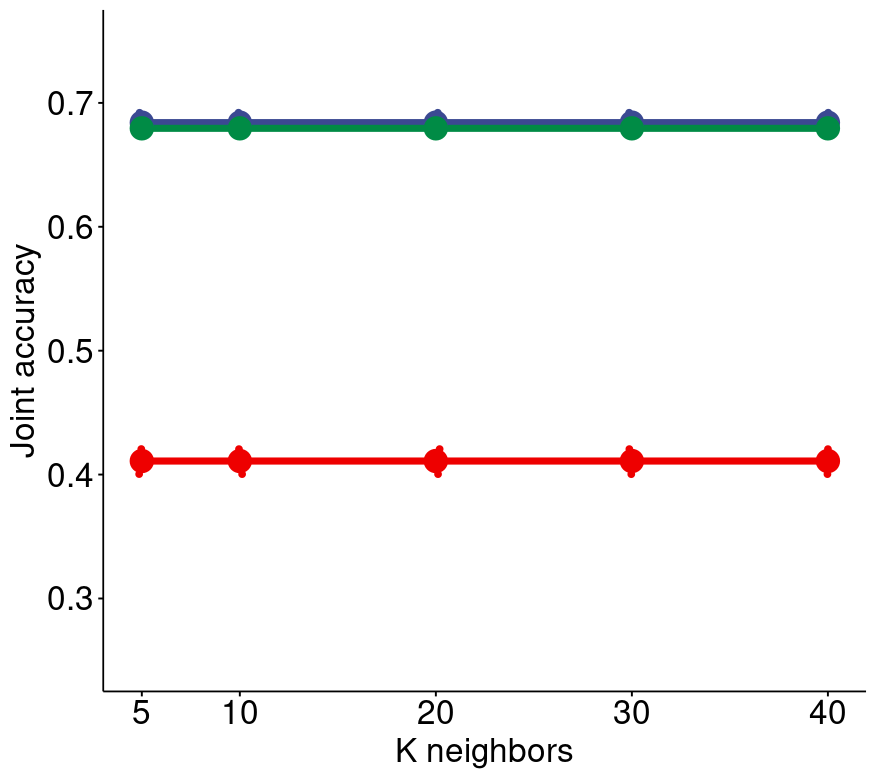

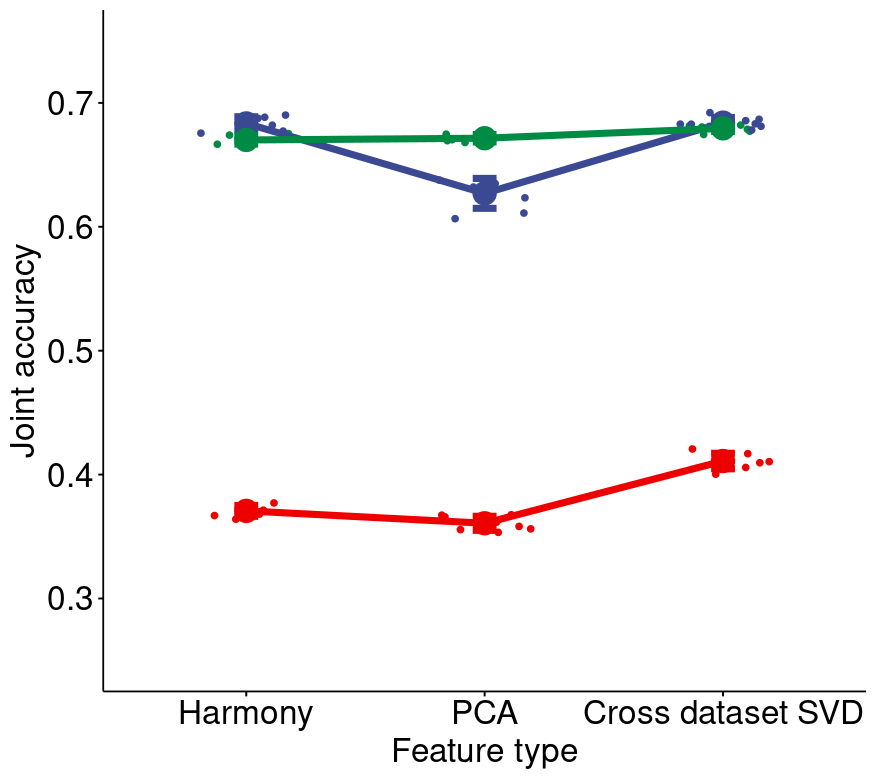

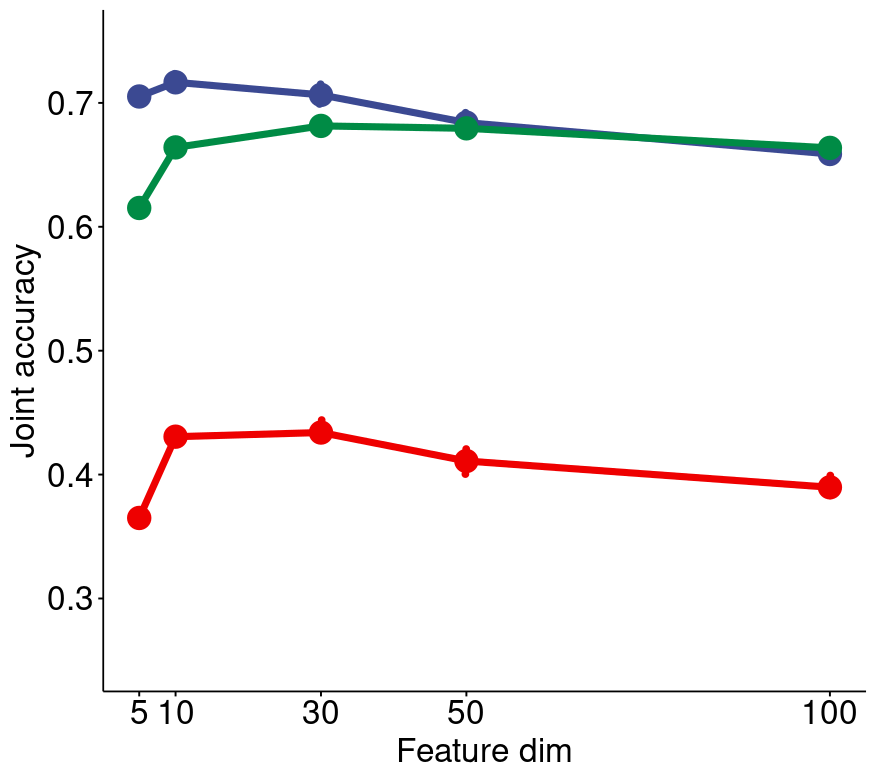

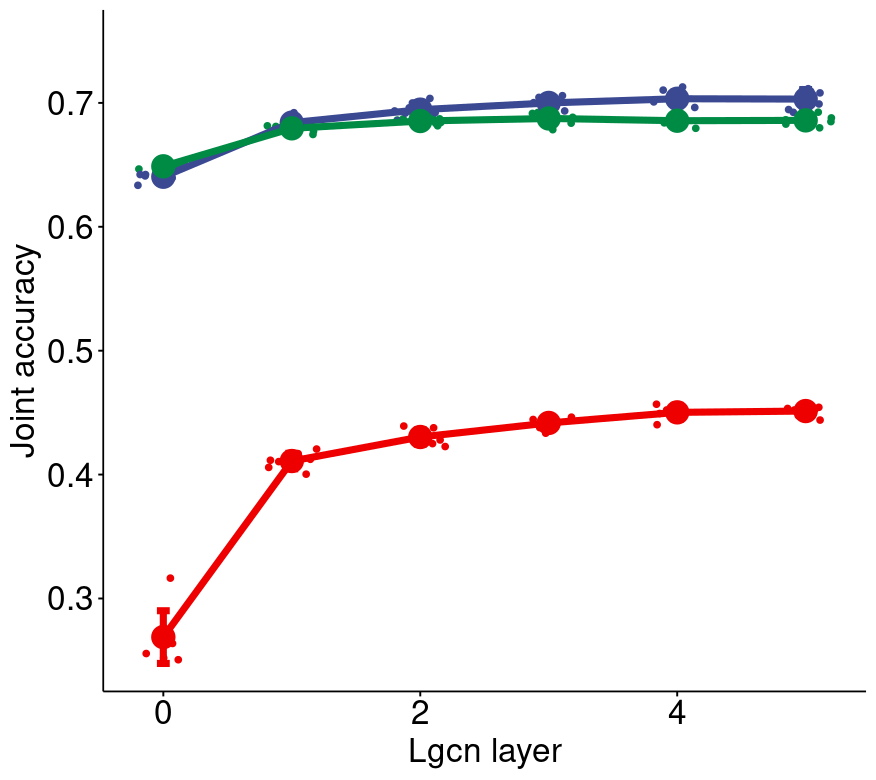

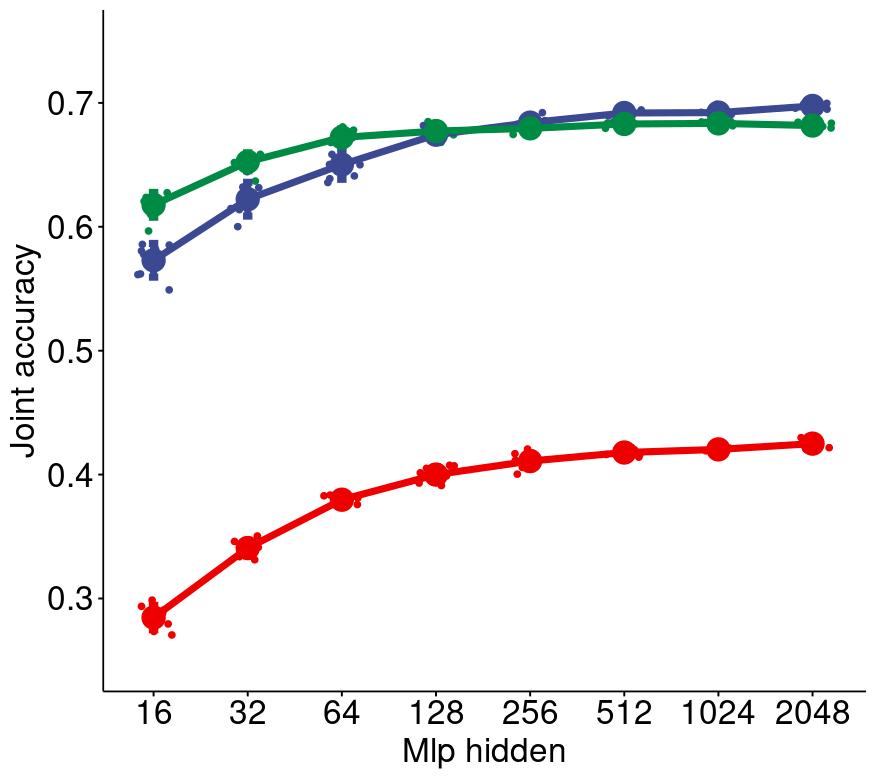

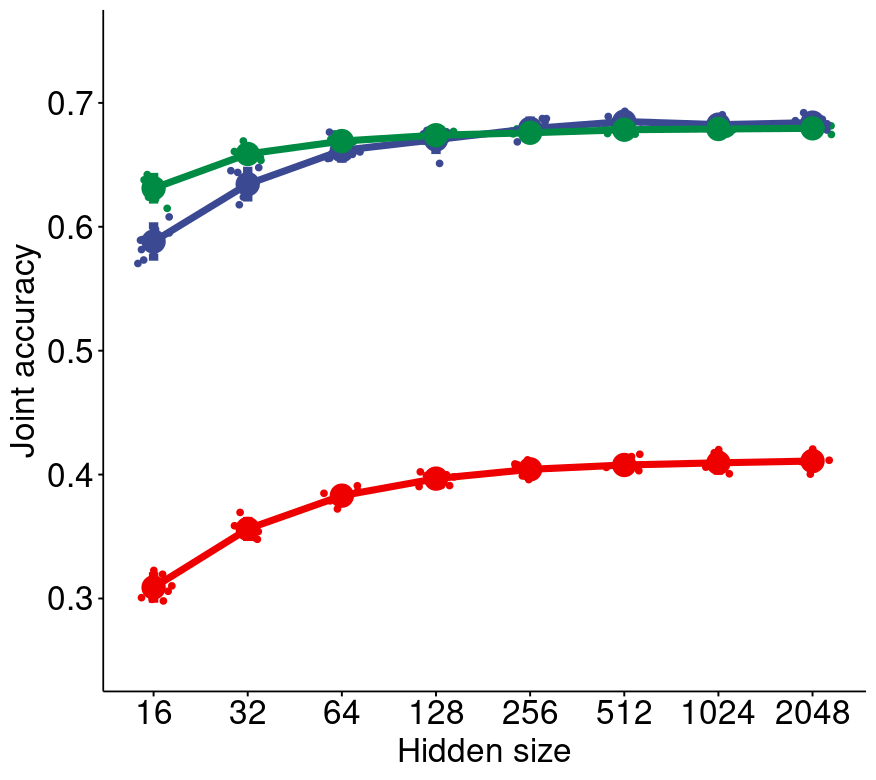

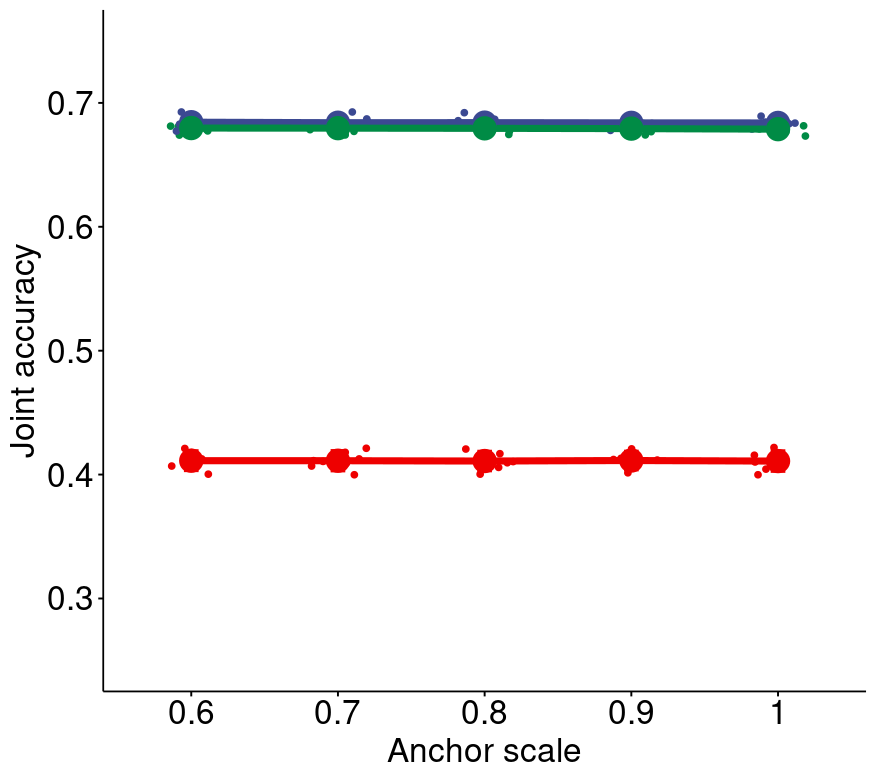

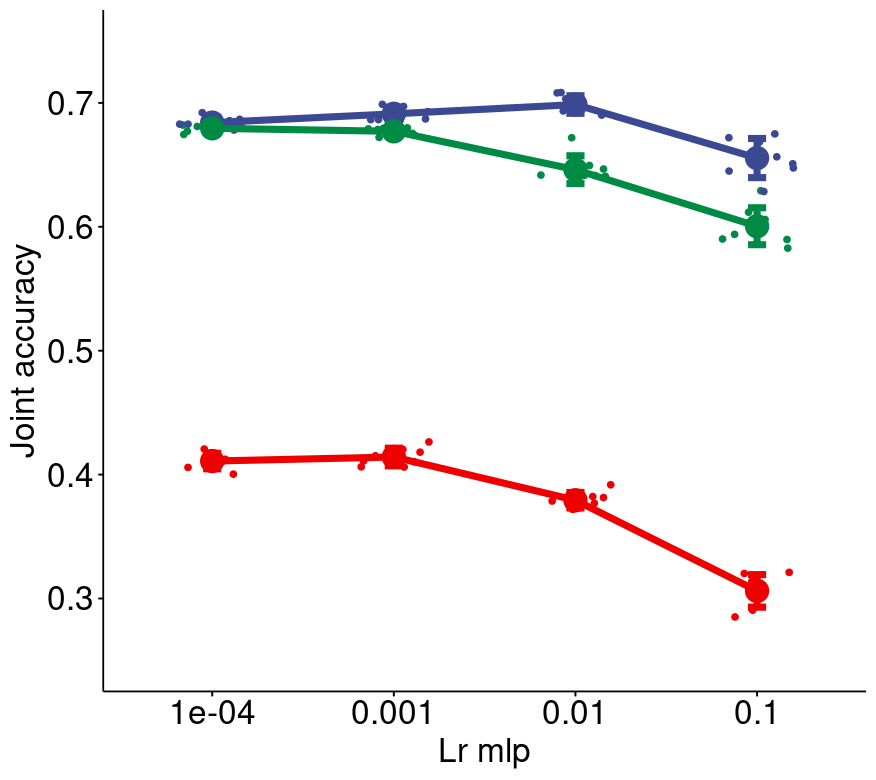

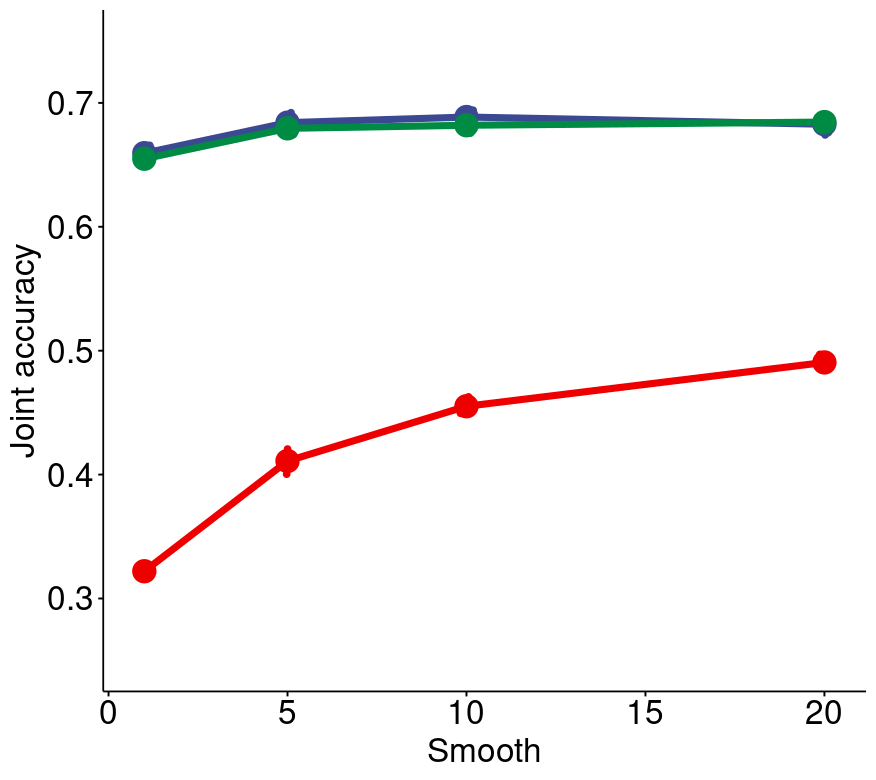

In [35]:
options(repr.plot.width = 7.3, repr.plot.height = 6.5)
for (param in names(default_param)) {
    # param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }


In [9]:
# For feature type only
df_filter <- df[which(df[[param_filter]] == tmp_default_param[param_filter]), ]


### For SVD

In [24]:
df <- read.csv("../results/hyperparam_slat.csv") 
df <- df %>%
    mutate(feature_type = replace(feature_type, feature_type == 'dpca', 'SVD-based correction')) %>%
    mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
    mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
    mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq')) %>%
    filter(feature_type %in% c('SVD-based correction', 'Harmony'))
df$dataset <- factor(df$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
df %>% tail(3)

,dataset,datasize,k_neighbors,feature_type,feature_dim,epochs,LGCN_layer,mlp_hidden,hidden_size,alpha,⋯,lr_recon,batch_d_per_iter,batch_r_per_iter,smooth,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<fct>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
934,Visium,8000,5,SVD-based correction,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,5,0.8485698,0.06658874,0.6811554,0.7835109,16.51446
935,Visium,8000,5,SVD-based correction,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,6,0.8407179,0.06791686,0.6867639,0.7966910,14.33310
936,Visium,8000,5,SVD-based correction,50,6,1,256,2048,0.01,⋯,0.01,7,10,5,7,0.8398766,0.06528853,0.6828379,0.7860348,15.81811


In [25]:
default_param <- c(k_neighbors =20, feature_type='SVD-based correction', feature_dim=50 ,epochs = 6, LGCN_layer = 1,
                    mlp_hidden = 256, hidden_size = 2048, alpha = 0.01, anchor_scale = "0.8",
                   lr_mlp = 0.0001, lr_wd = 0.0001, lr_recon = 0.01, batch_d_per_iter = 7, batch_r_per_iter = 10, smooth=5)
scores <- c("global_score")

In [26]:
plot_param_svd <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "feature_type", palette = c("#3b4992","#3b4992","#3b4992"), point.size = 5, size = 2,
                            ylab = "Joint accuracy", xlab='', facet.by = 'dataset') %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right") + 
            theme(axis.text.x=element_text(angle=15, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28)) +
            facet_wrap(~dataset, scales="free") +
            rremove("legend")
    return(plot)
}

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


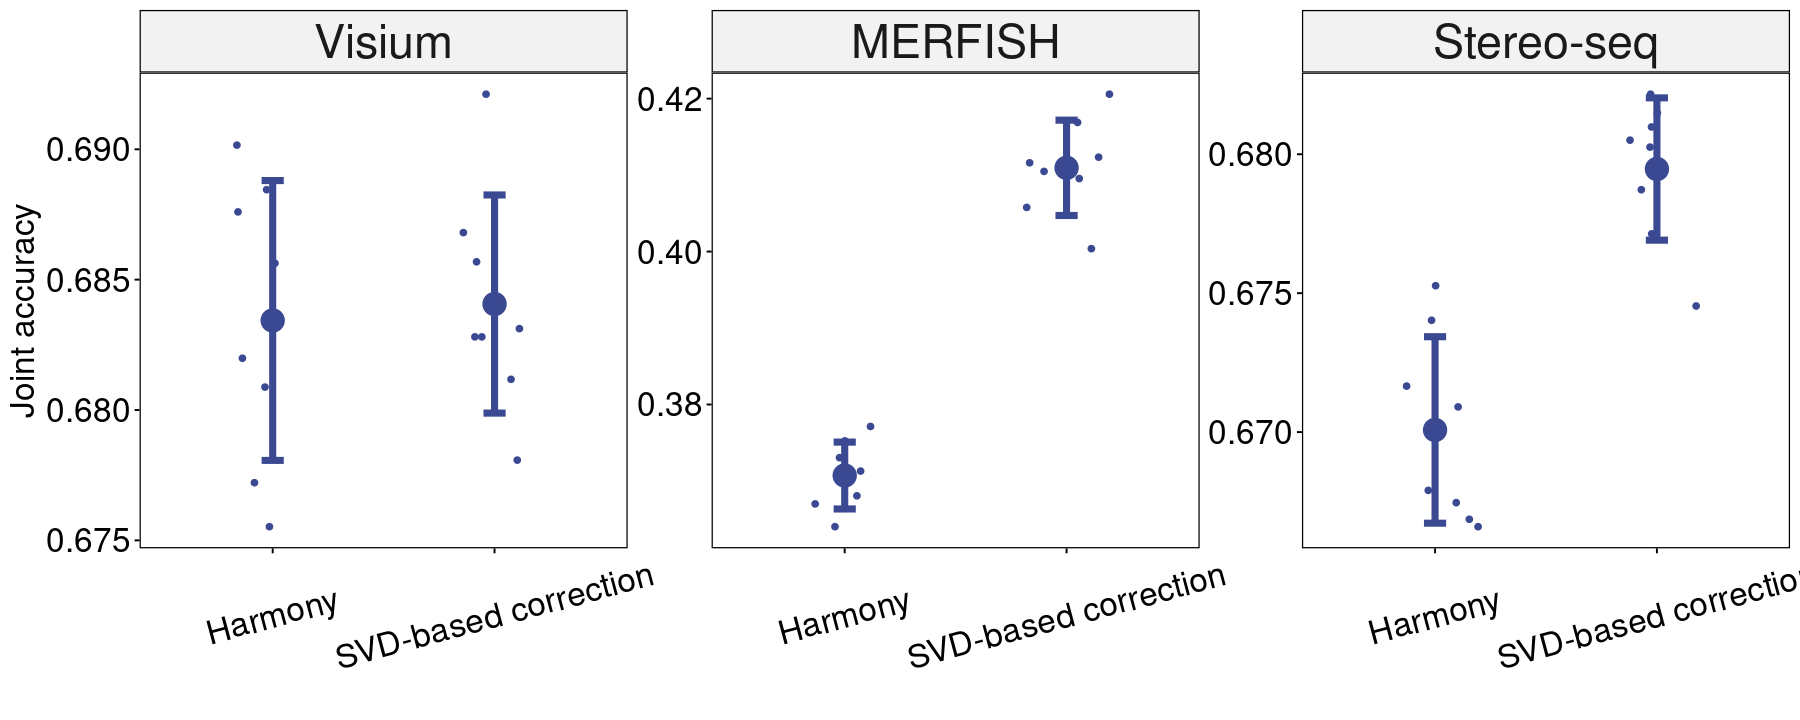

In [27]:
options(repr.plot.width = 15, repr.plot.height = 6)
for (param in names(default_param)) {
    # param %>% print()

    if (param != 'feature_type') {
        next
    }

    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param_svd(df_filter, score, param)
        print(p)
        }
    }


## Euclidean distance

In [13]:
plot_param_euc <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "feature_type", palette = c("#3b4992","#3b4992","#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Mean projection Euclidean  distance") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0, 0.1)) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        # plot <- plot + scale_x_continuous(trans='log2')
        if (str_detect(variable, 'size')) {
            plot <- plot + scale_x_continuous(breaks = c(32, 64, 128, 256, 512, 1024, 2048), trans='log2')
        } else if (str_detect(variable, 'mlp')){
            plot <- plot + scale_x_continuous(breaks = c(32, 64, 128, 256, 512), trans='log2')
        }

    } else if (str_detect(variable, 'batch_d_per_iter')) {
       plot <- plot + scale_x_continuous(breaks = c(1,3,5,7,9))
    } else if (str_detect(variable, 'dim')) {
       plot <- plot + scale_x_continuous(breaks = c(10,30,50,100))
    }
    return(plot)
}

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


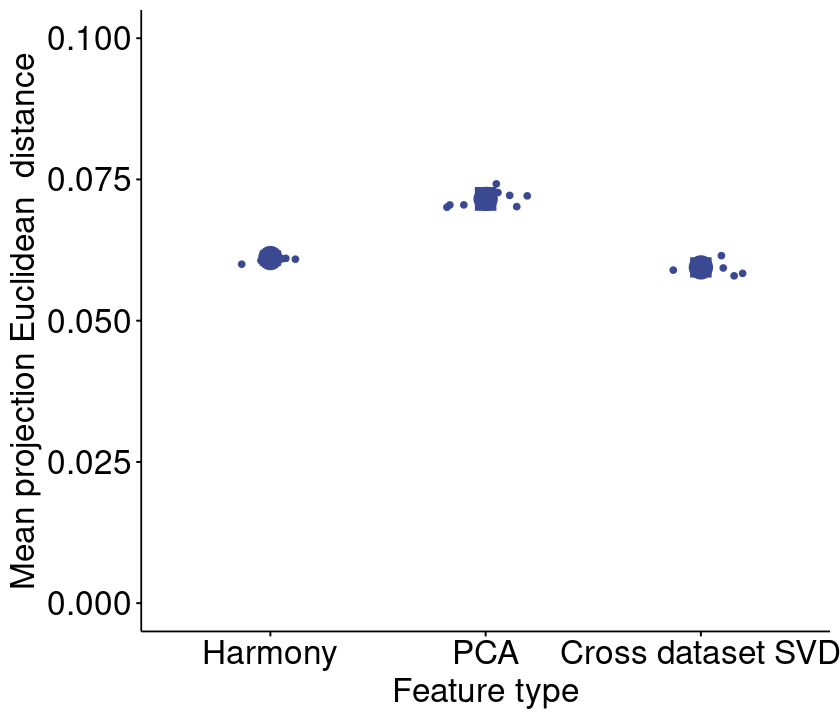

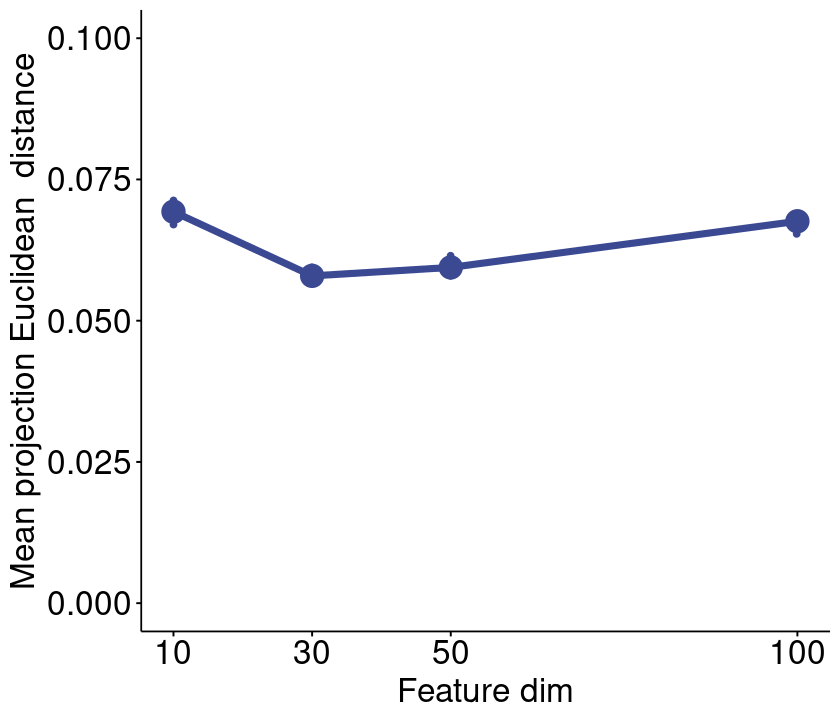

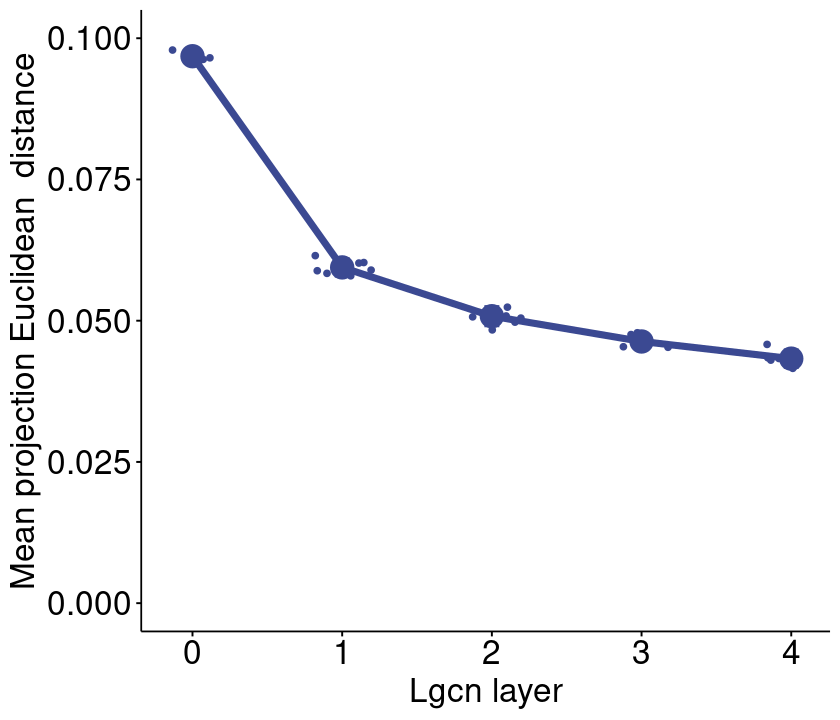

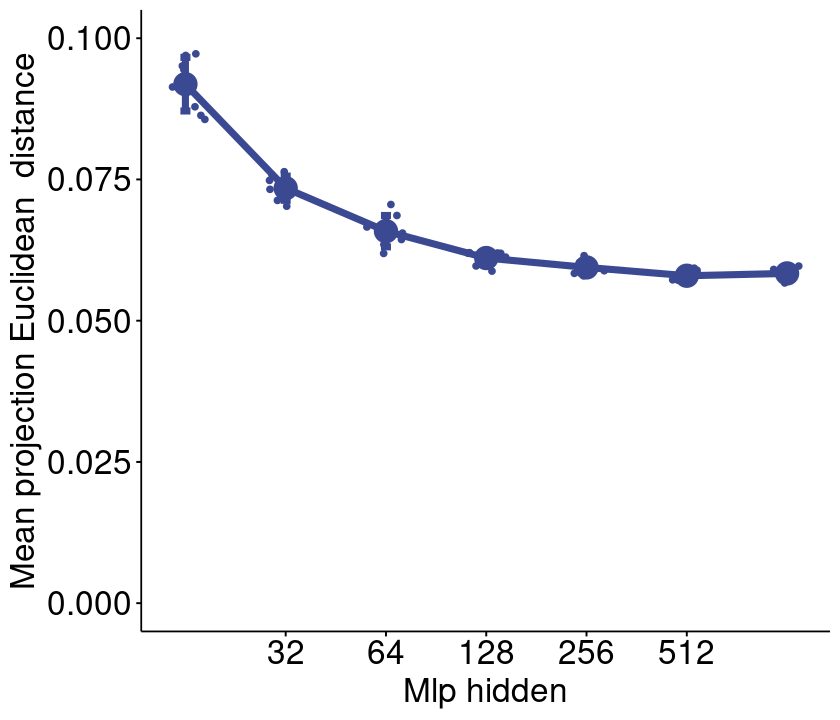

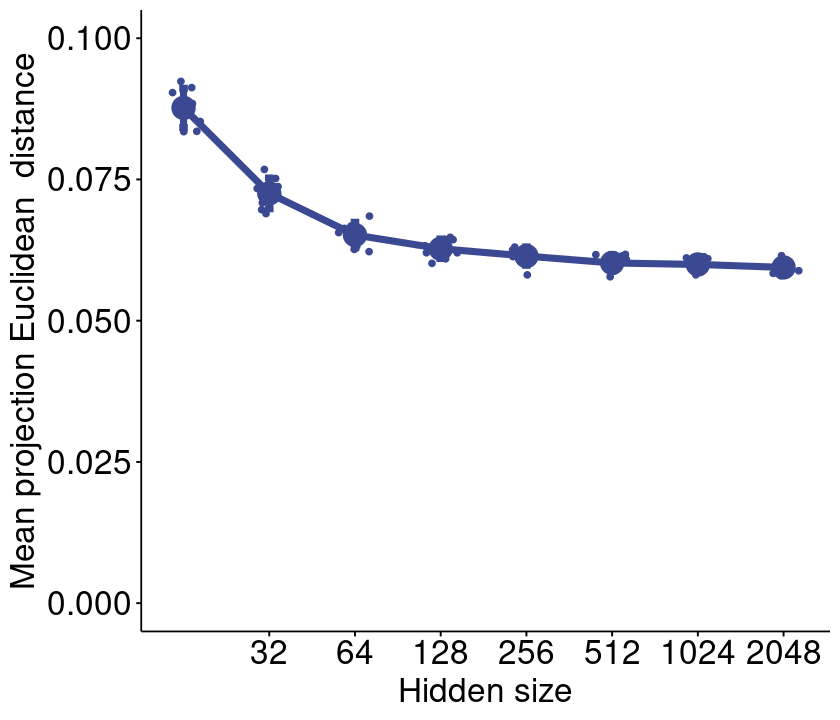

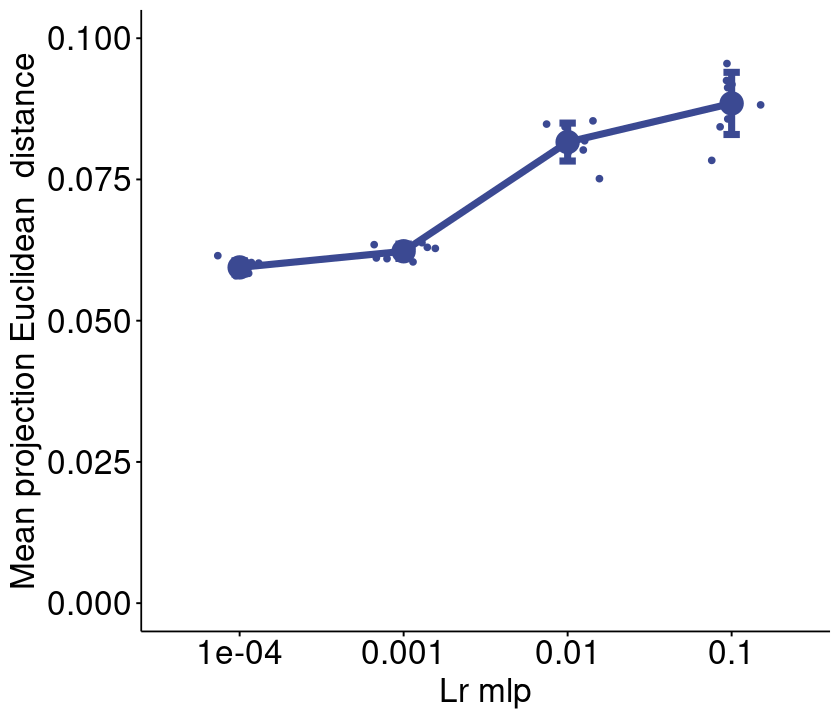

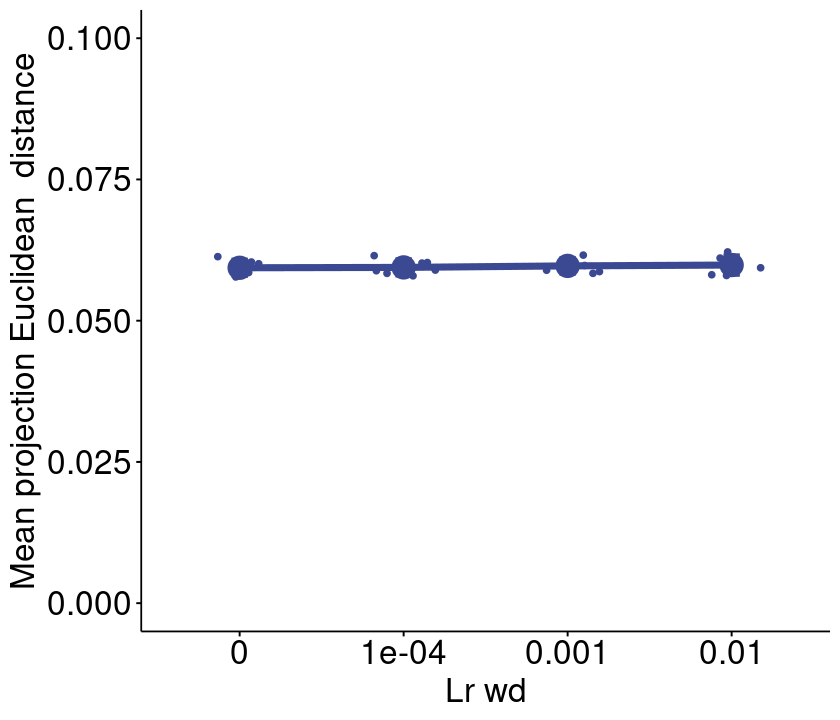

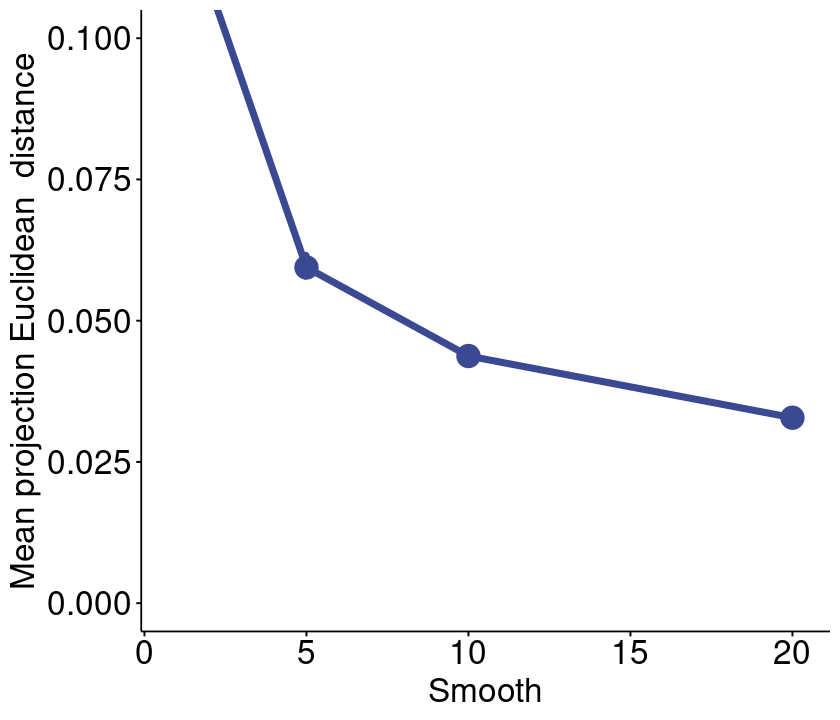

In [14]:
scores <- c("euclidean_dis")
options(repr.plot.width = 7, repr.plot.height = 6)
for (param in names(default_param)) {
    # param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        # print(df_filter %>% head(3))
        p <- plot_param_euc(df_filter, score, param)
        print(p)
        }
    }

# Harmony
## Joint accuracy


In [6]:
df <- read.csv("../results/hyperparam_harmony.csv") 
df %>% tail(3)

default_param <- c(feature_dim = 50, theta = 2, lambda = 1)
scores <- c("global_score")

,dataset,datasize,feature_dim,theta,lambda,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,stereo_mouse_embryo,8000,50,2,4,0,0.649375,0.2245725,0.556625,0.758875,27.27627
11,stereo_mouse_embryo,8000,50,3,1,0,0.649500,0.2250988,0.556125,0.757000,20.70382
12,stereo_mouse_embryo,8000,50,4,1,0,0.649500,0.2252348,0.556625,0.756375,33.86004


[1] "feature_dim"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


[1] "theta"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


[1] "lambda"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


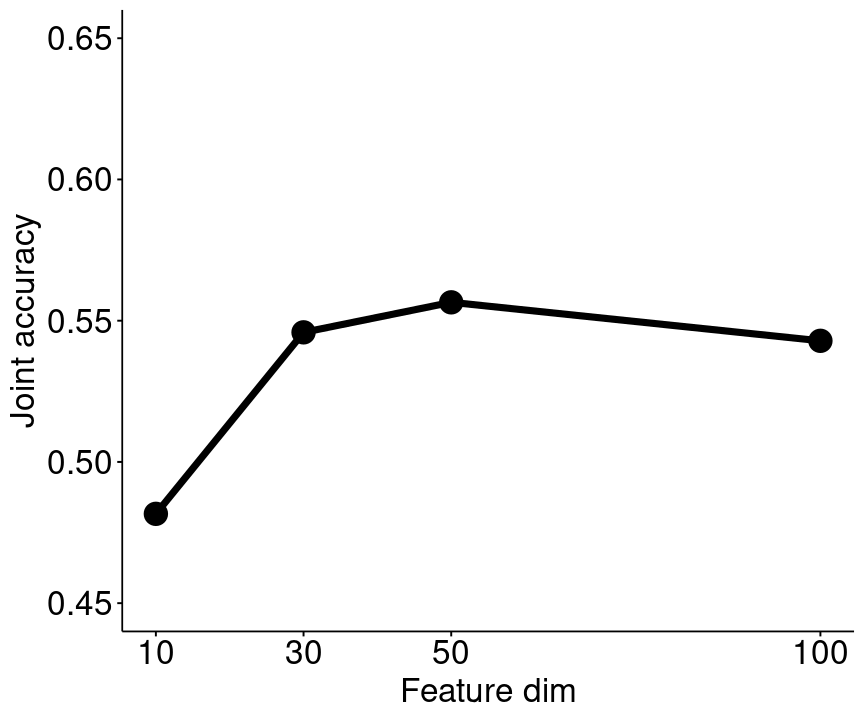

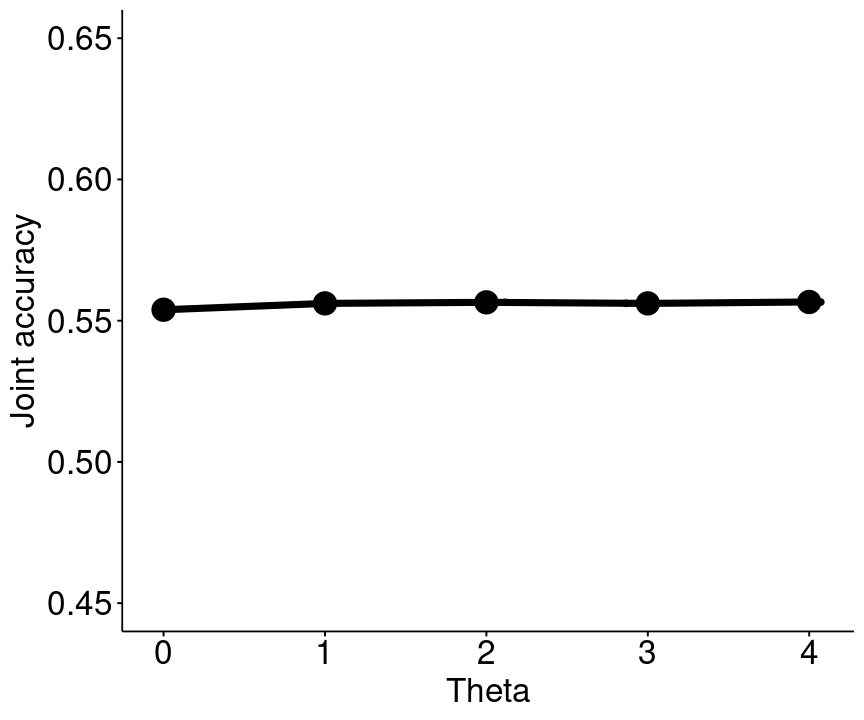

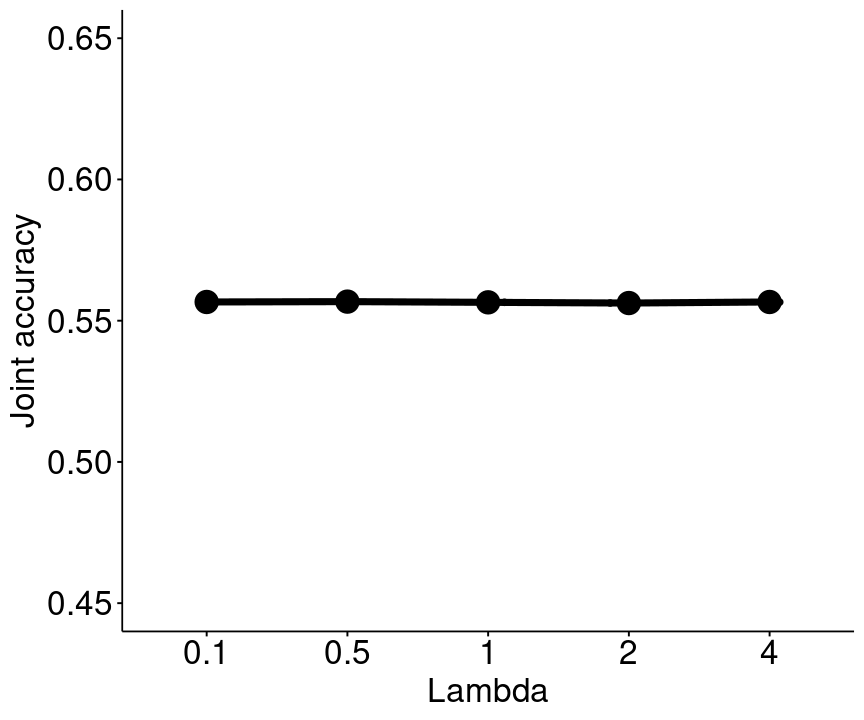

In [13]:
plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), palette = c("#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Joint accuracy") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.45, 0.65)) + 
            # geom_text(aes(label = round(get(score), 3)), vjust = "inward", hjust = "inward", show.legend = FALSE) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2')
    } else if (str_detect(variable, 'epochs')) {
       plot <- plot + scale_x_continuous(breaks = c(2,4,6,8,10))
    } else if (str_detect(variable, 'dim')) {
       plot <- plot + scale_x_continuous(breaks = c(0,10,30,50,100))
    }
    return(plot)
}

options(repr.plot.width = 7.2, repr.plot.height = 6)
for (param in names(default_param)) {
    param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }


# Seurat
## Joint accuracy

In [4]:
df <- read.csv("../results/hyperparam_seurat.csv") 
df %>% tail(3)

default_param <- c(anchor_feature = 2000, dim = 30, k_anchor = 5, k_filter = 200, k_score=50)
scores <- c("global_score")

,dataset,datasize,anchor_feature,dim,k_anchor,k_filter,k_score,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,stereo_mouse_embryo,8000,3000,30,5,200,50,0,0.689625,0.2005426,0.603375,0.802375,313.433
17,stereo_mouse_embryo,8000,5000,30,5,200,50,0,0.690750,0.2071436,0.609500,0.804500,448.661
18,stereo_mouse_embryo,8000,8000,30,5,200,50,0,0.697500,0.1962929,0.619375,0.820750,663.735


[1] "anchor_feature"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


[1] "dim"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


[1] "k_anchor"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


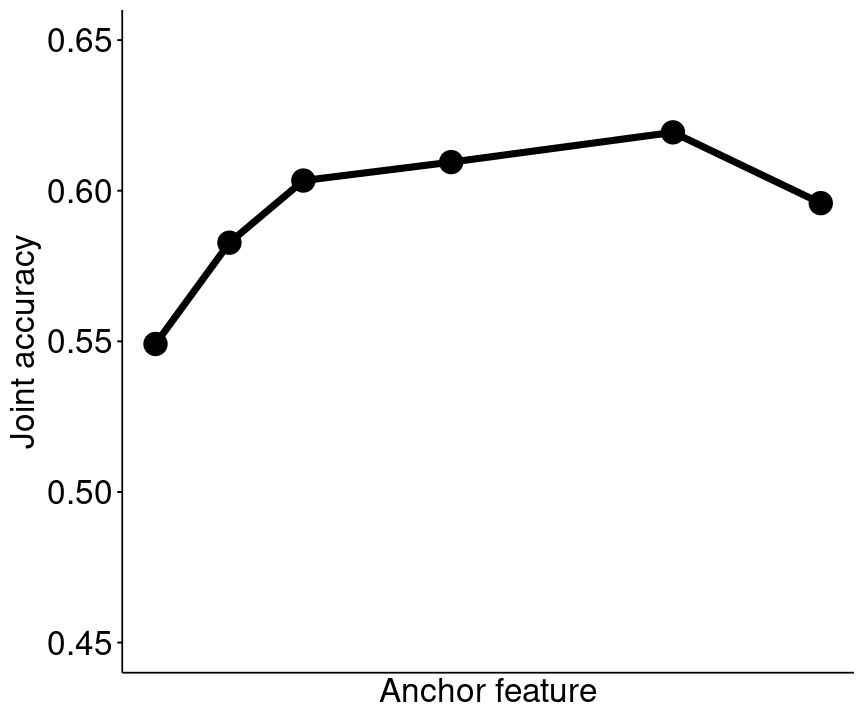

[1] "k_filter"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


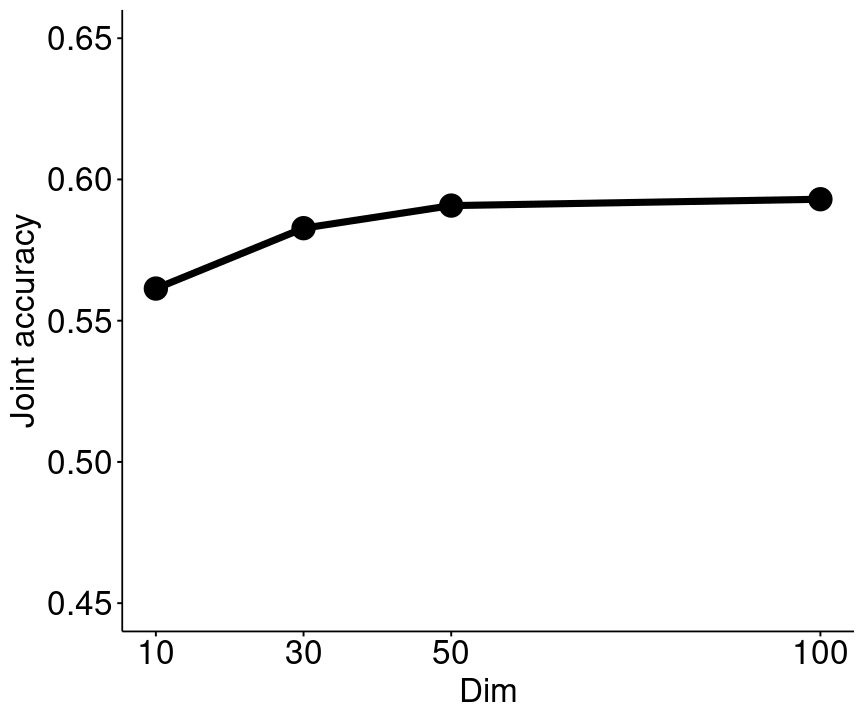

[1] "k_score"


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


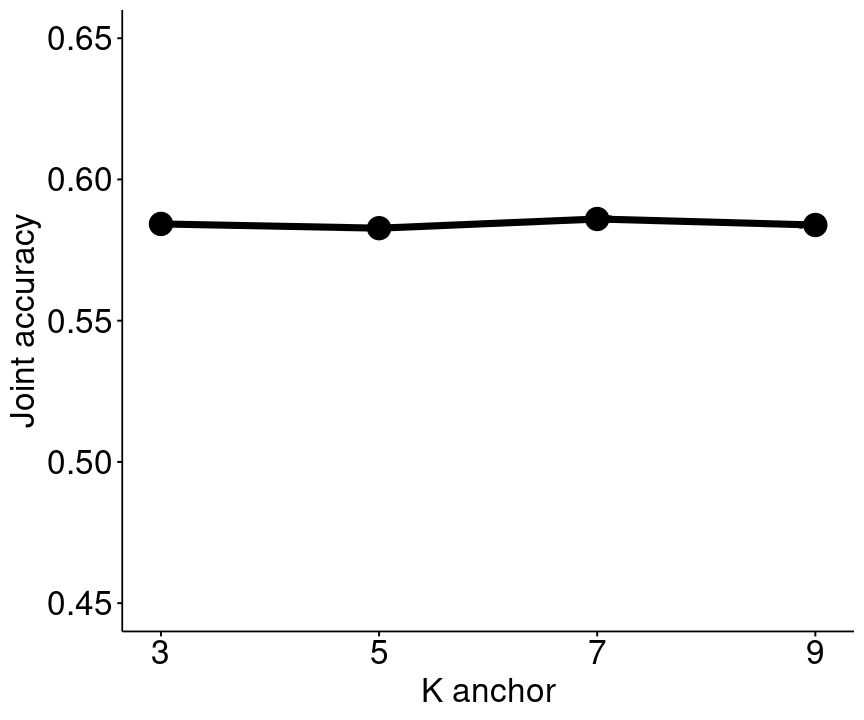

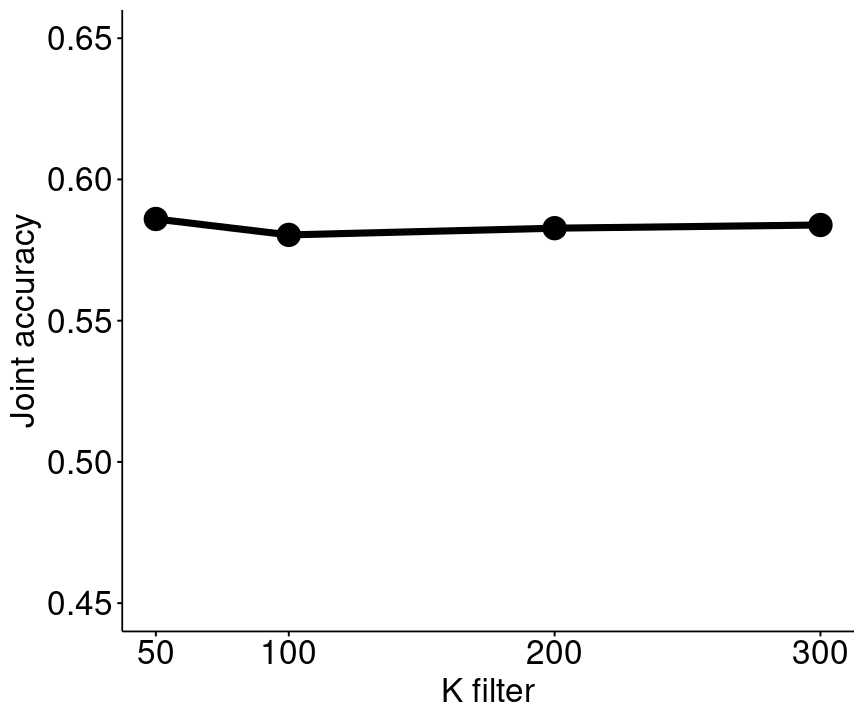

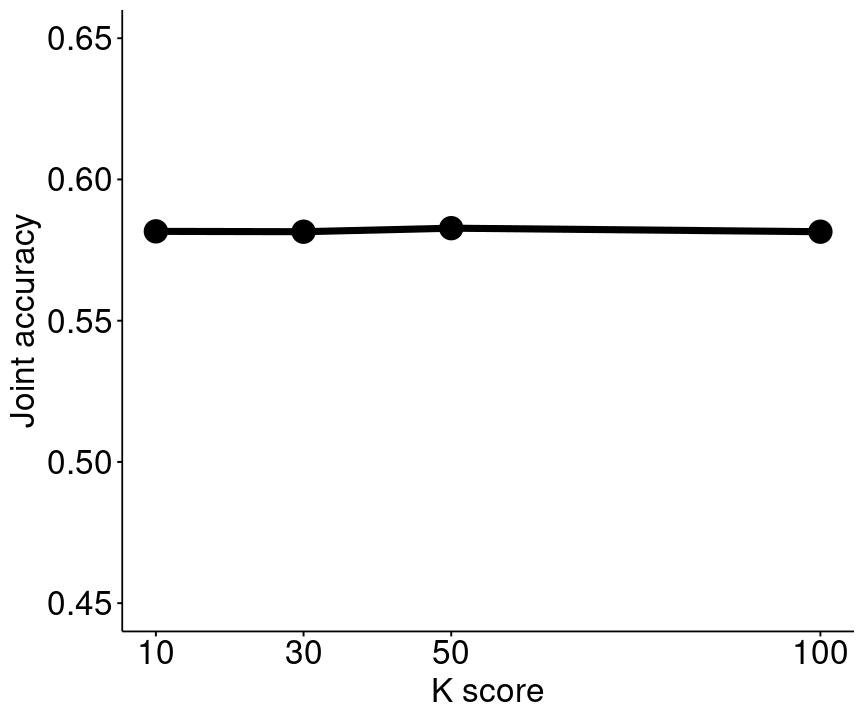

In [8]:
plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), palette = c("#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Joint accuracy") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.45, 0.65)) + 
            # geom_text(aes(label = round(get(score), 3)), vjust = "inward", hjust = "inward", show.legend = FALSE) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2')
    } else if (str_detect(variable, 'anchor')) {
       plot <- plot + scale_x_continuous(breaks = c(1,3,5,7,9))
    } else if (str_detect(variable, 'dim')) {
       plot <- plot + scale_x_continuous(breaks = c(0,10,30,50,100))
    } else if (str_detect(variable, 'score')) {
       plot <- plot + scale_x_continuous(breaks = c(0,10,30,50,100))
    } else if (str_detect(variable, 'filter')) {
       plot <- plot + scale_x_continuous(breaks = c(50,100,200,300))
    }
    return(plot)
}

options(repr.plot.width = 7.2, repr.plot.height = 6)
for (param in names(default_param)) {
    param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }


# PASTE
## Joint accuracy

In [2]:
df <- read.csv("../results/hyperparam_paste.csv") 
df %>% tail(3)

default_param <- c(alpha = 0.1)
scores <- c("global_score")

,dataset,datasize,alpha,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
46,stereo_mouse_embryo,8000,1,5,0.502125,0.03657229,0.488,0.89075,30.18551
47,stereo_mouse_embryo,8000,1,6,0.502125,0.03657229,0.488,0.89075,30.20543
48,stereo_mouse_embryo,8000,1,7,0.502125,0.03657229,0.488,0.89075,31.99181


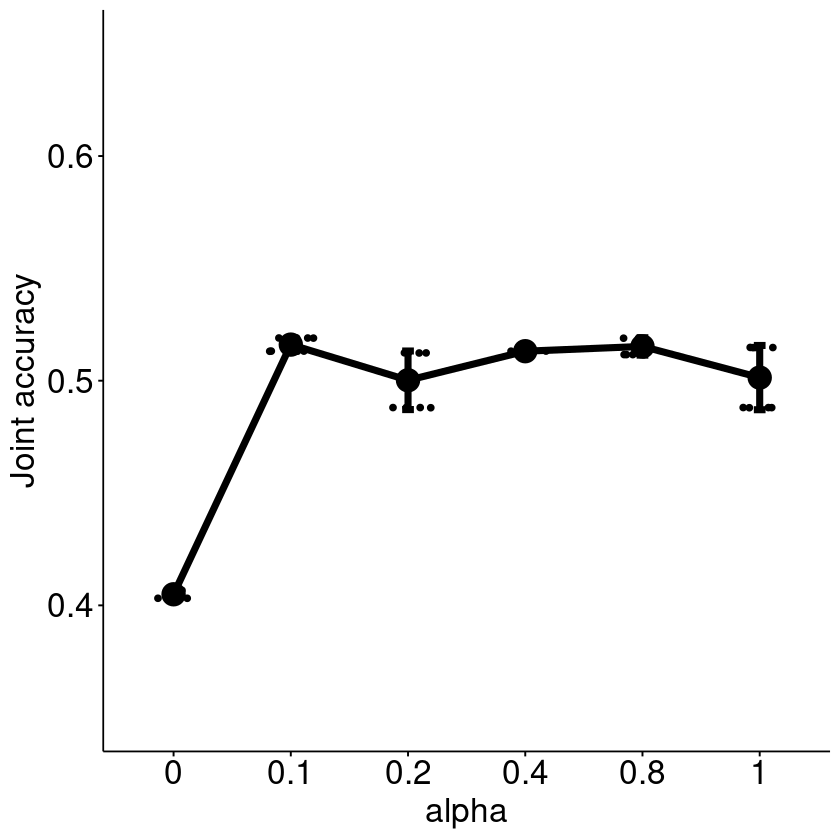

In [3]:
df %>% ggline('alpha', scores, add = c("mean_sd", "jitter"), palette = c("#3b4992"),
                    point.size = 5, size = 2,ylab = "Joint accuracy") %>%
        ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20,
             font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.35, 0.65))

# STAGATE
## Joint accuracy

In [12]:
df <- read.csv("../results/hyperparam_stagate.csv") 
df %>% tail(3)

default_param <- c(hidden_dim1 = 512, hidden_dim2 = 30, n_epochs = 1000, lr = 0.001)
scores <- c("global_score")

,dataset,datasize,hidden_dim1,hidden_dim2,n_epochs,lr,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102,stereo_mouse_embryo,8000,512,50,1000,0.001,5,0.698000,0.1284468,0.65425,0.861250,41.16359
103,stereo_mouse_embryo,8000,512,50,1000,0.001,6,0.694125,0.1324115,0.64950,0.857375,48.07330
104,stereo_mouse_embryo,8000,512,50,1000,0.001,7,0.694875,0.1333754,0.64850,0.854500,38.10604


[1] "hidden_dim1"
[1] "hidden_dim2"


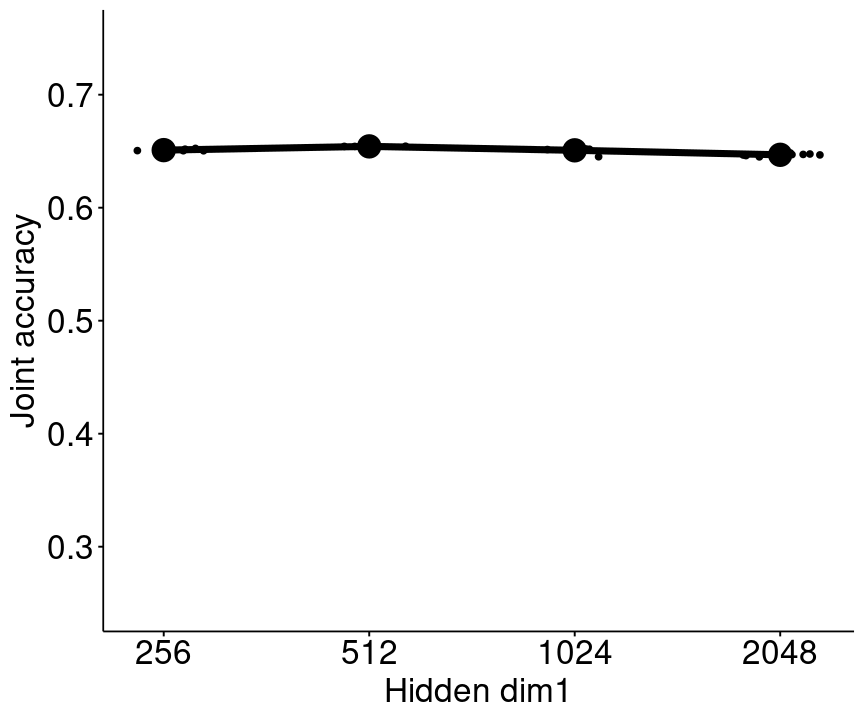

[1] "n_epochs"


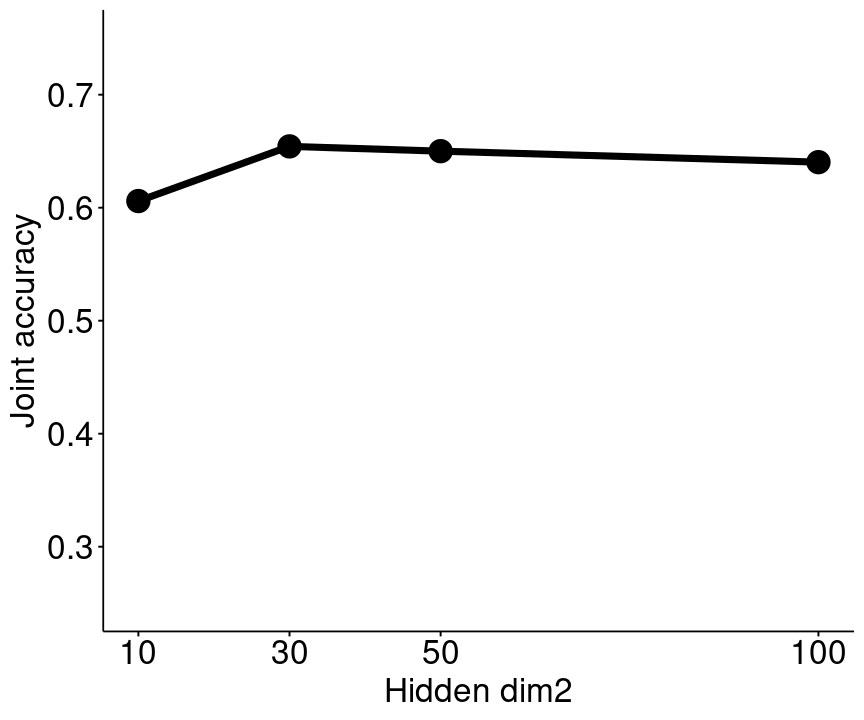

[1] "lr"


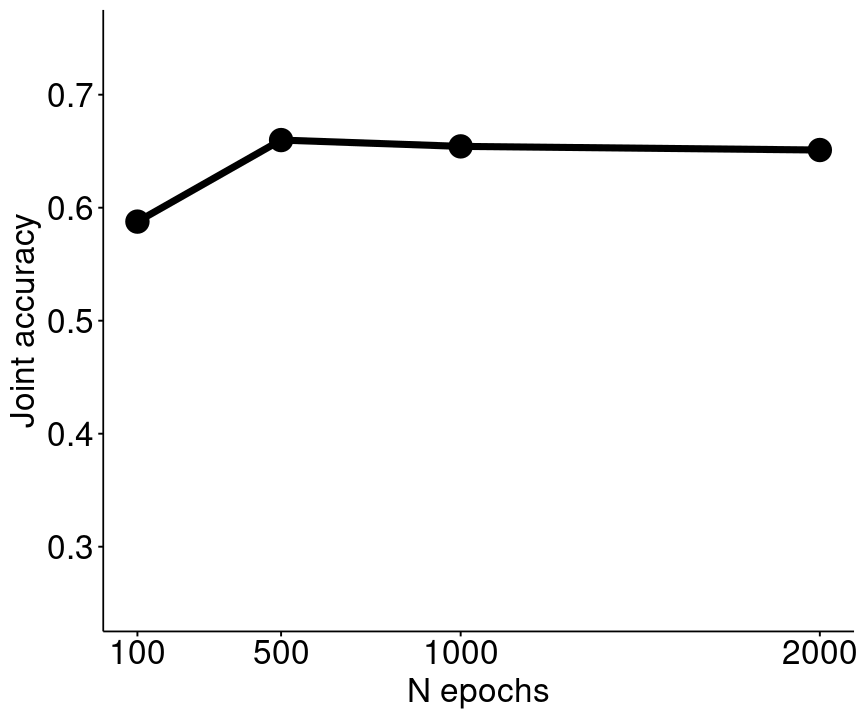

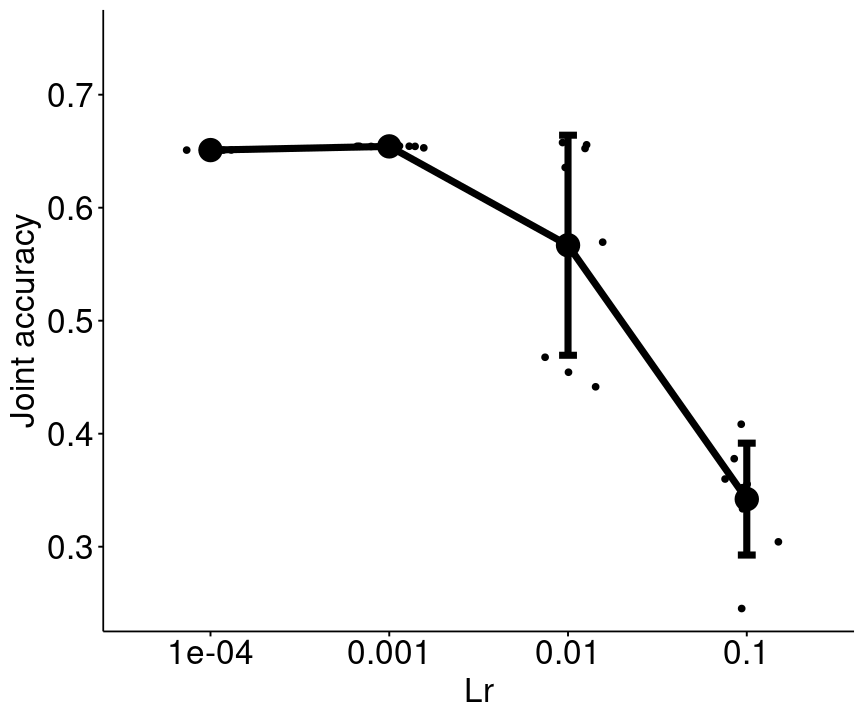

In [13]:
plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), palette = c("#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Joint accuracy") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.25, 0.75)) + 
            # geom_text(aes(label = round(get(score), 3)), vjust = "inward", hjust = "inward", show.legend = FALSE) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'dim1')) {
        plot <- plot + scale_x_continuous(trans='log2')
    } else if (str_detect(variable, 'dim2')) {
       plot <- plot + scale_x_continuous(breaks = c(10, 30, 50, 100))
    } else if (str_detect(variable, 'epochs')) {
       plot <- plot + scale_x_continuous(breaks = c(100, 500, 1000, 2000))
    }
    return(plot)
}


options(repr.plot.width = 7.2, repr.plot.height = 6)
for (param in names(default_param)) {
    param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }


# LGCN ablation study

In [2]:
df <- read.csv("../results/hyperparam_slat.merfish.csv")
df <- df %>% filter(dataset %in% c('merfish_mouse_hypothalamic')) %>% 
    mutate(feature_type = replace(feature_type, feature_type == 'dpca', 'Cross dataset SVD'))
df %>% tail(3)

,dataset,datasize,k_neighbors,feature_type,feature_dim,epochs,LGCN_layer,mlp_hidden,hidden_size,alpha,⋯,lr_recon,batch_d_per_iter,batch_r_per_iter,smooth,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69,merfish_mouse_hypothalamic,8000,20,Cross dataset SVD,50,6,5,256,2048,0.01,⋯,0.01,7,10,5,5,0.7640362,0.09497846,0.4529008,0.5821896,179.0411
70,merfish_mouse_hypothalamic,8000,20,Cross dataset SVD,50,6,5,256,2048,0.01,⋯,0.01,7,10,5,6,0.7624766,0.09605091,0.4533687,0.5918590,180.1322
71,merfish_mouse_hypothalamic,8000,20,Cross dataset SVD,50,6,5,256,2048,0.01,⋯,0.01,7,10,5,7,0.7577979,0.09232787,0.4522770,0.5878041,179.6403


In [27]:
default_param <- c(k_neighbors =20, feature_type='Cross dataset SVD', feature_dim=50 ,epochs = 6, LGCN_layer = 1,
                    mlp_hidden = 256, hidden_size = 2048, alpha = 0.01, anchor_scale = "0.8",
                   lr_mlp = 0.0001, lr_wd = 0.0001, lr_recon = 0.01, batch_d_per_iter = 7, batch_r_per_iter = 10, smooth=5)
scores <- c("global_score", "region_score", "celltype_score")

plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    # print(df)
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "feature_type", palette = c("#3b4992","#3b4992","#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = score) %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.2, 0.8)) + 
            # geom_text(aes(label = round(get(score), 3)), vjust = "inward", hjust = "inward", show.legend = FALSE) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2', breaks = c(16, 32, 64, 128, 256, 512, 1024, 2048))
    } else if (str_detect(variable, 'epochs')) {
       plot <- plot + scale_x_continuous(breaks = c(2,4,6,8,10))
    } else if (str_detect(variable, 'dim')) {
       plot <- plot + scale_x_continuous(breaks = c(10,30,50,100))
    }
    return(plot)
}

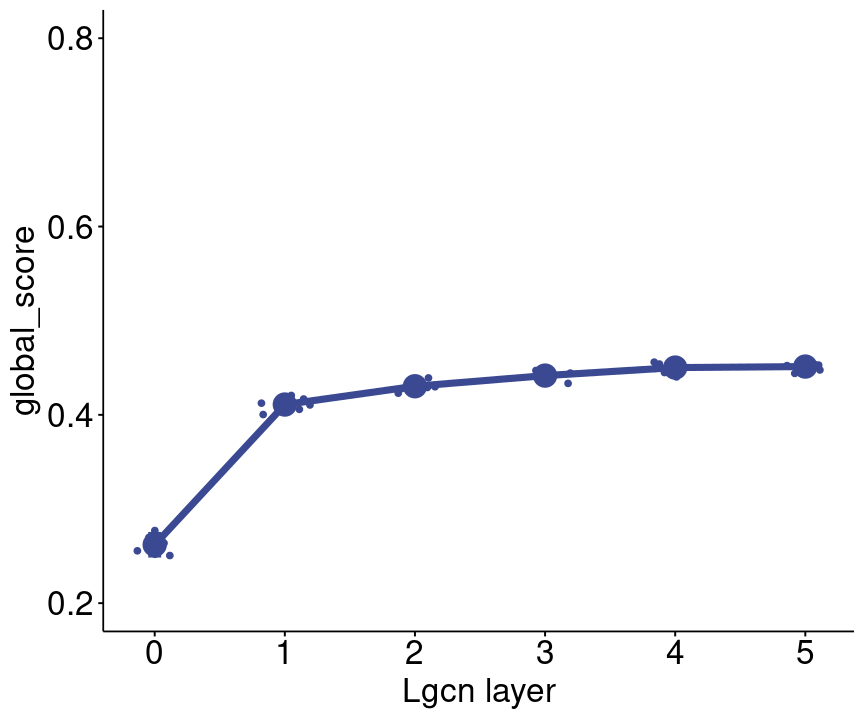

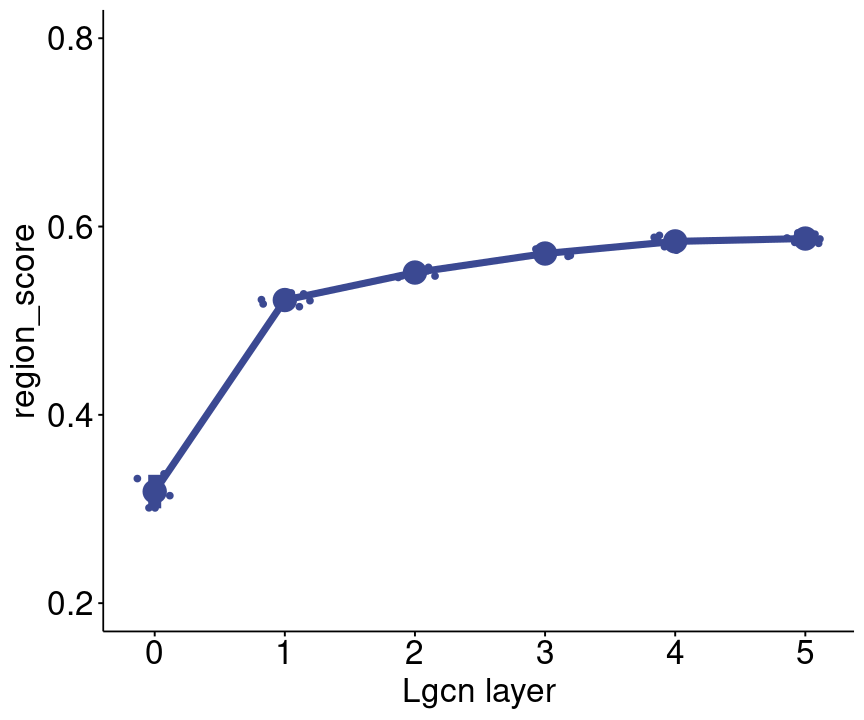

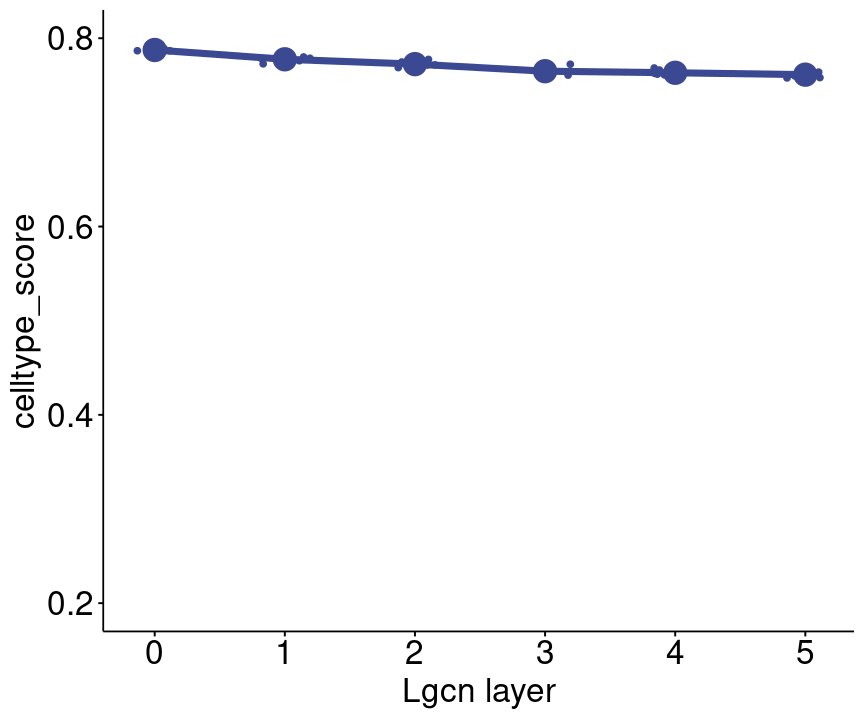

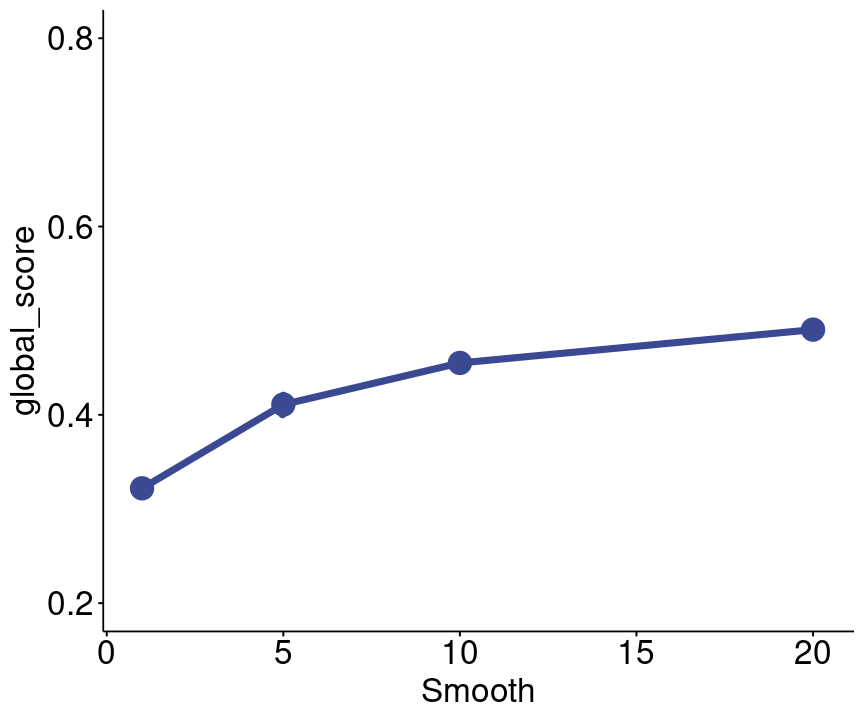

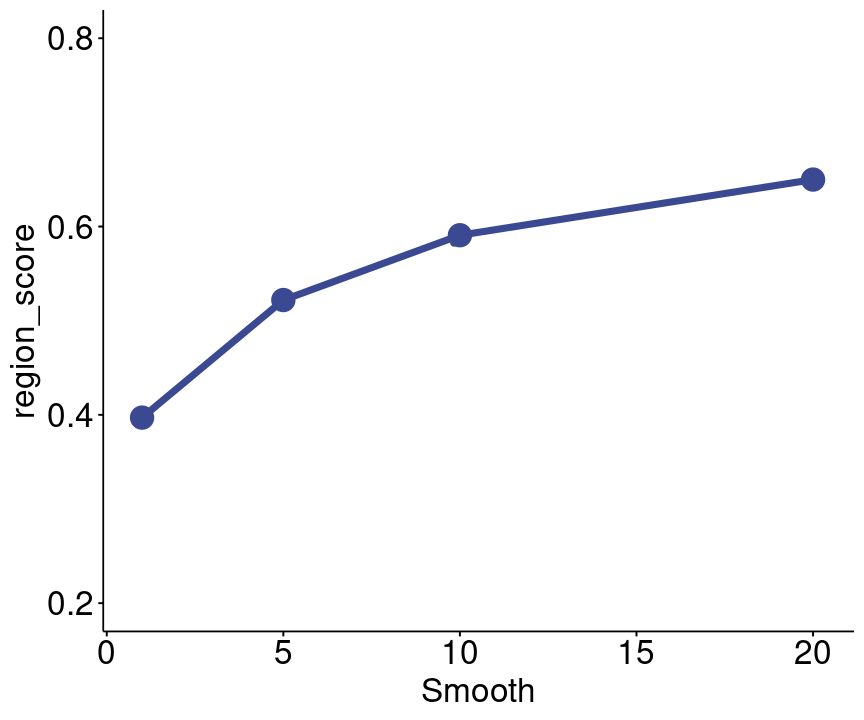

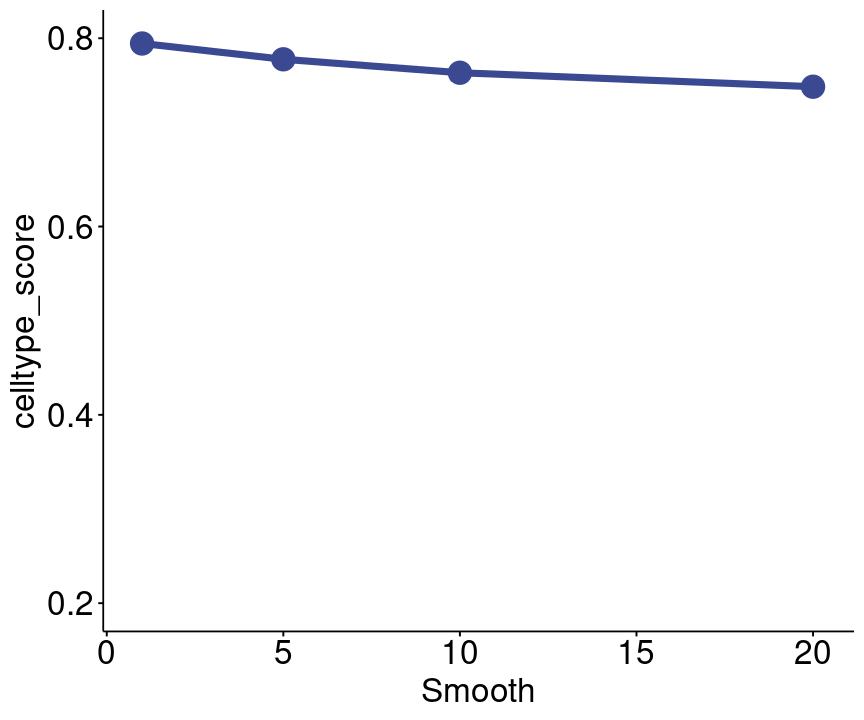

In [28]:
options(repr.plot.width = 7.2, repr.plot.height = 6)
for (param in names(default_param)) {
    # param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }
